Fetching data for BABA with 2 years of warm-up history...
Engineering Features (FracDiff, Yang-Zhang)...
Detecting Market Regimes (Unsupervised Learning w/ Walk-Forward)...
Training GMM with Expanding Window (Start: 252 days, Step: 20 days)...
Signals Generated.

--- Institutional Performance Report: BABA ---
Total Return:   4.91%
Sharpe Ratio:   0.64  (>1.0 is Good)
Sortino Ratio:  0.75  (>1.5 is Excellent)
Max Drawdown:   -8.70% (Pain Threshold)
Calmar Ratio:   0.56
---------------------------------------------------

Plotting polished results... (Close window to finish)


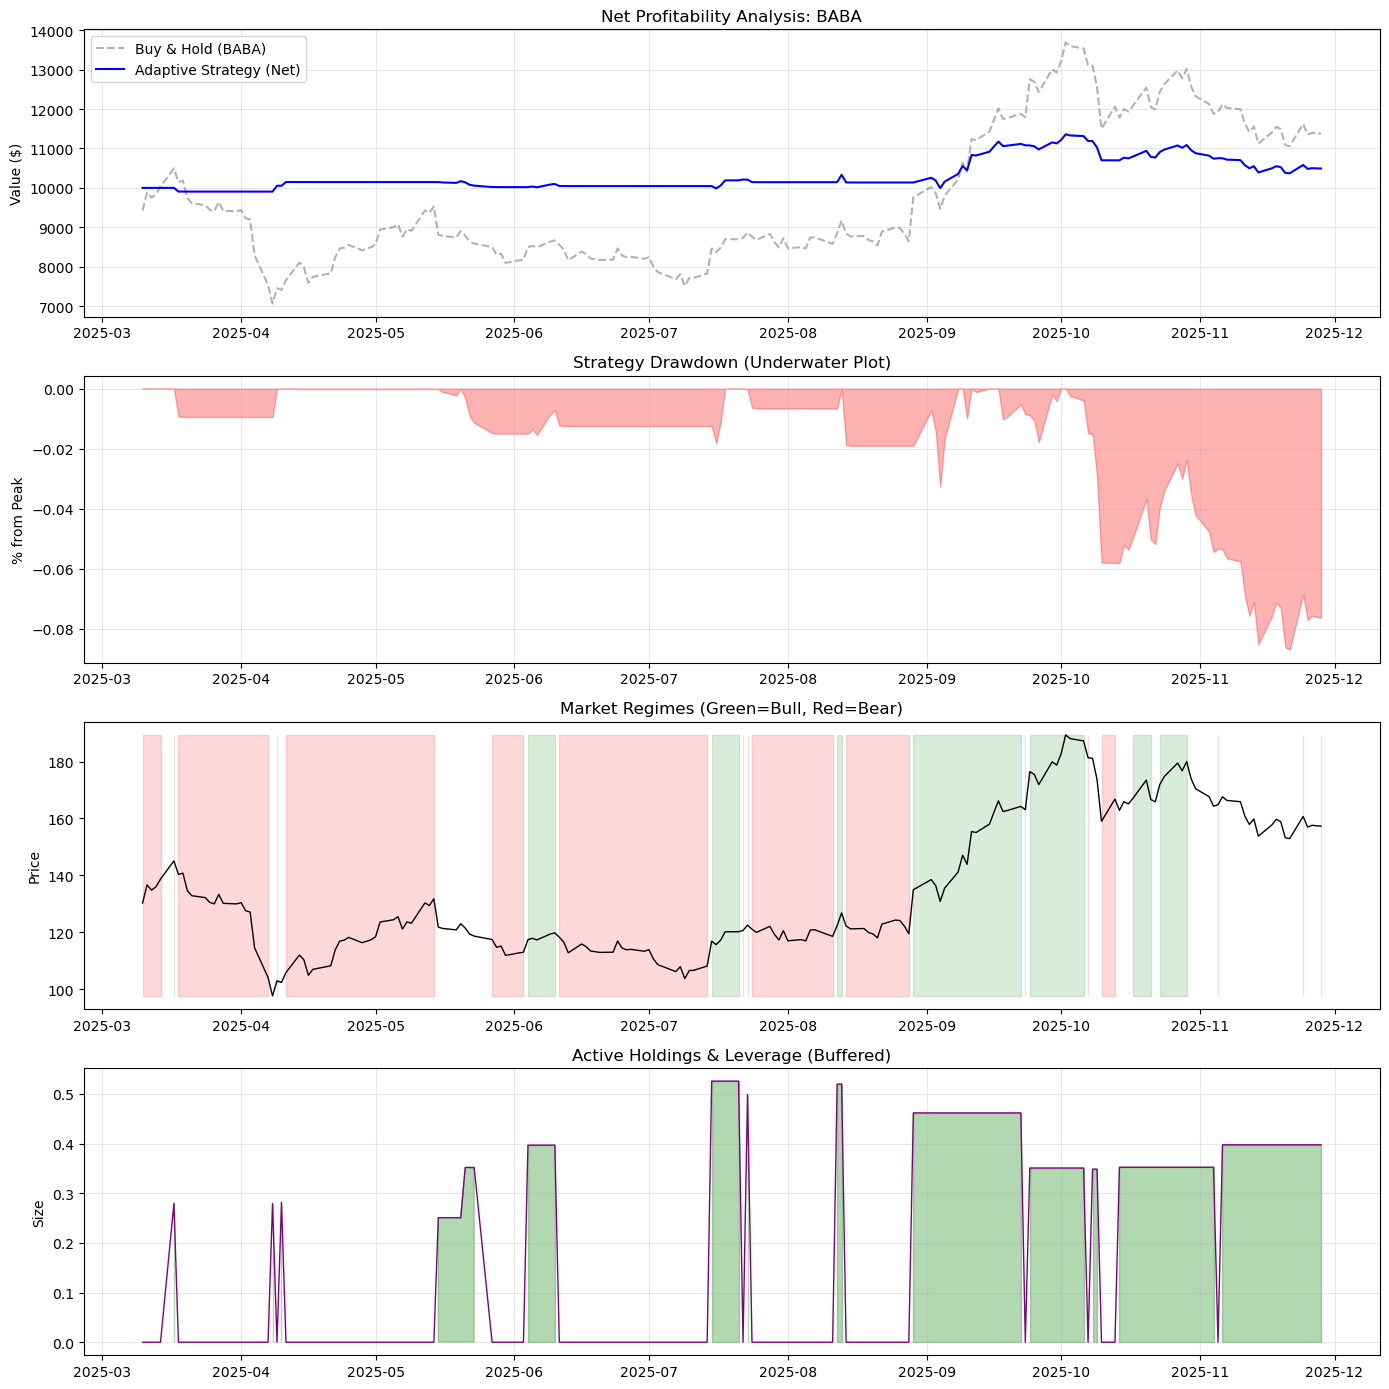

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
import warnings
from datetime import datetime, timedelta

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ==========================================
# 1. ADVANCED FEATURE ENGINEERING (Math Lab)
# ==========================================

class FeatureLab:
    """
    Implements advanced signal processing techniques described in the MIT research plan.
    Includes Fractional Differentiation and Yang-Zhang Volatility.
    """

    @staticmethod
    def get_weights_frac_diff(d, size, threshold=1e-5):
        """
        Calculates weights for fractional differentiation using the binomial expansion.
        Ref: Section 2.1.1 of Research Plan.
        """
        w = [1.0]
        for k in range(1, size):
            w_k = -w[-1] / k * (d - k + 1)
            w.append(w_k)
        
        w = np.array(w[::-1])
        w = w[np.abs(w) > threshold]
        return w

    @staticmethod
    def frac_diff_fixed(series, d, window=50):
        """
        Applies fractional differentiation to a pandas Series.
        Preserves memory while achieving stationarity.
        """
        weights = FeatureLab.get_weights_frac_diff(d, window)
        # Apply dot product over rolling window
        res = series.rolling(window=len(weights)).apply(lambda x: np.dot(x, weights), raw=True)
        return res

    @staticmethod
    def yang_zhang_volatility(df, window=30):
        """
        Computes Yang-Zhang Volatility: Minimum variance, unbiased, drift-independent.
        Ref: Section 2.2 of Research Plan.
        """
        log_ho = (df['High'] / df['Open']).apply(np.log)
        log_lo = (df['Low'] / df['Open']).apply(np.log)
        log_co = (df['Close'] / df['Open']).apply(np.log)
        
        log_oc = (df['Open'] / df['Close'].shift(1)).apply(np.log)
        log_cc = (df['Close'] / df['Close'].shift(1)).apply(np.log)
        
        rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)
        
        close_vol = log_cc.rolling(window=window).var()
        open_vol = log_oc.rolling(window=window).var()
        window_rs = rs.rolling(window=window).mean()

        k = 0.34 / (1.34 + (window + 1) / (window - 1))
        
        yz_vol = np.sqrt(open_vol + k * window_rs)
        return yz_vol

    @staticmethod
    def compute_relative_strength(series, window=14):
        """Standard RSI for Mean Reversion components."""
        delta = series.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))

# ==========================================
# 2. MARKET REGIME DETECTION (Behavioral Lab)
# ==========================================

class RegimeIdentifier:
    """
    Uses Unsupervised Learning (GMM) to decode latent market states.
    Ref: Section 3.1 & 3.2 of Research Plan.
    """
    def __init__(self, n_components=3):
        # 3 components: 0=Bear/HighVol, 1=Sideways, 2=Bull/LowVol
        self.n_components = n_components
        self.is_fitted = False

    def fit_predict(self, df, min_window=252, step=20):
        """
        Fits GMM on an EXPANDING WINDOW to prevent look-ahead bias.
        """
        data = df.copy().dropna()
        
        # Use Rolling Mean of Returns to classify "Trend" not "Noise"
        data['Returns_Smoothed'] = data['Returns'].rolling(window=5).mean()
        data['Volatility_Smoothed'] = data['Volatility'].rolling(window=5).mean()
        data.dropna(inplace=True)

        data['Regime_Label'] = np.nan
        
        if len(data) <= min_window:
            print(f"Warning: Not enough data (Need > {min_window}, got {len(data)})")
            return data

        print(f"Training GMM with Expanding Window (Start: {min_window} days, Step: {step} days)...")
        
        predictions = []
        indices = []
        
        # Iterate through time
        for t in range(min_window, len(data), step):
            train_df = data.iloc[:t]
            test_df = data.iloc[t : t + step]
            
            if test_df.empty:
                break
                
            X_train = train_df[['Returns_Smoothed', 'Volatility_Smoothed']].values
            X_test = test_df[['Returns_Smoothed', 'Volatility_Smoothed']].values
            
            # 1. Fit Scaler on TRAIN only
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            
            # 2. Fit GMM on TRAIN
            model = GaussianMixture(n_components=self.n_components, covariance_type="full", random_state=42)
            model.fit(X_train_scaled)
            
            # 3. Predict on TEST
            pred_labels = model.predict(X_test_scaled)
            
            # 4. DYNAMIC MAPPING (Map Clusters to Semantic Meaning)
            train_labels = model.predict(X_train_scaled)
            temp_train = train_df.copy()
            temp_train['Cluster'] = train_labels
            
            # Sort clusters by Mean Return
            cluster_stats = temp_train.groupby('Cluster')['Returns_Smoothed'].mean()
            sorted_clusters = cluster_stats.sort_values().index
            
            mapping = {
                sorted_clusters[0]: -1, # Bear
                sorted_clusters[1]: 0,  # Sideways
                sorted_clusters[2]: 1   # Bull
            }
            
            mapped_preds = [mapping[label] for label in pred_labels]
            predictions.extend(mapped_preds)
            indices.extend(test_df.index)

        # Assign predictions
        pred_series = pd.Series(predictions, index=indices)
        data.loc[pred_series.index, 'Regime_Label'] = pred_series
        
        # Drop warm-up NaN period
        data.dropna(subset=['Regime_Label'], inplace=True)
        
        self.is_fitted = True
        return data

# ==========================================
# 3. STRATEGY ABSTRACTION
# ==========================================

class Strategy(ABC):
    """Abstract Base Class for all trading strategies."""
    
    def __init__(self, ticker, start_date, end_date):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        self.results = None

    def fetch_data(self, warmup_years=2):
        """
        Fetches data with an automatic warm-up period.
        
        Args:
            warmup_years (int): Number of extra years of history to fetch before start_date.
                                This ensures indicators (GMM, FracDiff) are stable by start_date.
        """
        print(f"Fetching data for {self.ticker} with {warmup_years} years of warm-up history...")
        
        # Calculate fetch start date (Start Date - Warmup Years)
        start_dt = datetime.strptime(self.start_date, "%Y-%m-%d")
        warmup_start_dt = start_dt - timedelta(days=warmup_years*365)
        warmup_start_str = warmup_start_dt.strftime("%Y-%m-%d")
        
        try:
            self.data = yf.download(self.ticker, start=warmup_start_str, end=self.end_date, progress=False, auto_adjust=False)
        except Exception as e:
            print(f"Warning: Download failed: {e}")
            return

        if isinstance(self.data.columns, pd.MultiIndex):
            self.data.columns = self.data.columns.get_level_values(0)

        if 'Adj Close' not in self.data.columns:
            if 'Close' in self.data.columns:
                print("Note: Using 'Close' as fallback for 'Adj Close'.")
                self.data['Adj Close'] = self.data['Close']
            else:
                raise KeyError(f"Price columns missing for {self.ticker}.")

        self.data['Returns'] = self.data['Adj Close'].pct_change()
        self.data.dropna(inplace=True)

    @abstractmethod
    def generate_signals(self):
        pass

    def run_backtest(self, initial_capital=10000, transaction_cost=0.0005, rebalance_threshold=0.1):
        """
        Vectorized Backtest Engine with Transaction Costs and Trade Buffering.
        
        Args:
            transaction_cost (float): Cost per trade (e.g., 0.0005 = 5bps = 0.05%)
            rebalance_threshold (float): Minimum change in position size required to trigger a trade.
                                         (e.g., 0.1 means position must change by 10%).
        """
        if 'Signal' not in self.data.columns:
            raise ValueError("Signals not generated yet.")
        
        # 1. Slice Data: Discard Warm-up period for the Backtest Analysis
        # We only want to test from the user's requested START date
        backtest_mask = self.data.index >= self.start_date
        # Note: We need one row prior to start_date for shift logic, but simple slicing is safer 
        # given the regime detection is already done.
        df = self.data.loc[backtest_mask].copy()
        
        if df.empty:
            raise ValueError(f"No data found starting from {self.start_date}. Check date ranges.")

        # 2. Apply Trade Buffering (Hysteresis)
        # Iterate to apply rebalance logic: Only trade if abs(New - Old) > Threshold
        clean_positions = []
        current_pos = 0.0
        
        # Pre-convert to numpy for speed
        raw_signals = df['Signal'].values
        
        for target in raw_signals:
            if abs(target - current_pos) > rebalance_threshold:
                current_pos = target
            clean_positions.append(current_pos)
            
        df['Position'] = clean_positions
        
        # 3. Calculate Returns
        # Shift Position by 1 to simulate trading at NEXT Open/Close based on Today's decision
        df['Prev_Position'] = df['Position'].shift(1)
        df['Prev_Position'].fillna(0, inplace=True)
        
        # Calculate Turnover (Change in held position)
        df['Turnover'] = (df['Prev_Position'] - df['Position'].shift(2).fillna(0)).abs()
        
        # Gross Returns (Strategy Return = Prev_Position * Day_Return)
        df['Gross_Returns'] = df['Prev_Position'] * df['Returns']
        
        # Net Returns (Subtract transaction costs)
        df['Net_Returns'] = df['Gross_Returns'] - (df['Turnover'] * transaction_cost)
        
        # Fill NaNs
        df['Net_Returns'].fillna(0, inplace=True)
        df['Returns'].fillna(0, inplace=True)
        
        # Cumulative
        df['Cumulative_Market'] = (1 + df['Returns']).cumprod() * initial_capital
        df['Cumulative_Strategy'] = (1 + df['Net_Returns']).cumprod() * initial_capital
        
        # Track Drawdown for Strategy
        roll_max = df['Cumulative_Strategy'].cummax()
        df['Drawdown'] = (df['Cumulative_Strategy'] / roll_max) - 1.0
        
        self.results = df
        return df

    def performance_metrics(self):
        df = self.results
        
        # 1. Total Return
        total_return = (df['Cumulative_Strategy'].iloc[-1] / df['Cumulative_Strategy'].iloc[0]) - 1
        
        # 2. Sharpe Ratio (Annualized)
        daily_excess = df['Net_Returns']
        sharpe = (daily_excess.mean() / daily_excess.std()) * np.sqrt(252)
        
        # 3. Max Drawdown
        max_drawdown = df['Drawdown'].min()
        
        # 4. Sortino Ratio (Downside Deviation only)
        negative_returns = daily_excess[daily_excess < 0]
        downside_std = negative_returns.std()
        sortino = (daily_excess.mean() / downside_std) * np.sqrt(252) if downside_std != 0 else np.nan
        
        # 5. Calmar Ratio
        calmar = (total_return / abs(max_drawdown)) if max_drawdown != 0 else np.nan

        print(f"\n--- Institutional Performance Report: {self.ticker} ---")
        print(f"Total Return:   {total_return:.2%}")
        print(f"Sharpe Ratio:   {sharpe:.2f}  (>1.0 is Good)")
        print(f"Sortino Ratio:  {sortino:.2f}  (>1.5 is Excellent)")
        print(f"Max Drawdown:   {max_drawdown:.2%} (Pain Threshold)")
        print(f"Calmar Ratio:   {calmar:.2f}")
        print("---------------------------------------------------")
        
        return total_return, sharpe

# ==========================================
# 4. CONCRETE STRATEGY: ADAPTIVE REGIME
# ==========================================

class AdaptiveRegimeStrategy(Strategy):
    """
    Implements the core thesis: Different regimes require different logic.
    Ref: Section 1.1 & 3.3 of Research Plan.
    """

    def generate_signals(self):
        print("Engineering Features (FracDiff, Yang-Zhang)...")
        
        self.data['Volatility'] = FeatureLab.yang_zhang_volatility(self.data)
        # Use window=50 for stable long-term memory
        self.data['FracDiff'] = FeatureLab.frac_diff_fixed(self.data['Adj Close'].apply(np.log), d=0.4, window=50)
        self.data['RSI'] = FeatureLab.compute_relative_strength(self.data['Adj Close'])
        
        self.data.dropna(inplace=True)
        
        # Detect Regimes (Expanding Window)
        print("Detecting Market Regimes (Unsupervised Learning w/ Walk-Forward)...")
        regime_engine = RegimeIdentifier()
        self.data = regime_engine.fit_predict(self.data, min_window=252, step=20)
        
        # Logic Application
        self.data['Signal'] = 0
        
        # BULL (1): Trend Following
        bull_condition = (self.data['Regime_Label'] == 1) & (self.data['FracDiff'] > 0)
        self.data.loc[bull_condition, 'Signal'] = 1
        
        # SIDEWAYS (0): Mean Reversion (Dip Buy)
        sideways_long = (self.data['Regime_Label'] == 0) & (self.data['RSI'] < 40)
        self.data.loc[sideways_long, 'Signal'] = 1
        
        # BEAR (-1): Cash
        bear_condition = (self.data['Regime_Label'] == -1)
        self.data.loc[bear_condition, 'Signal'] = 0 
        
        # MOMENTUM OVERRIDE (Stay long in strong trends even if RSI is high, unless extreme)
        strong_trend_override = (self.data['Regime_Label'] == 0) & \
                                (self.data['FracDiff'] > 1e-4) & \
                                (self.data['RSI'] > 40) & \
                                (self.data['RSI'] < 80)
        self.data.loc[strong_trend_override, 'Signal'] = 1

        # Volatility Targeting (Risk Management)
        # Target 15% Annualized Volatility
        target_vol = 0.15 / np.sqrt(252)
        self.data['Vol_Scaler'] = target_vol / self.data['Volatility']
        self.data['Vol_Scaler'] = self.data['Vol_Scaler'].clip(upper=1.5) 
        
        self.data['Signal'] = self.data['Signal'] * self.data['Vol_Scaler']

        print("Signals Generated.")

    def plot_results(self):
        plt.figure(figsize=(14, 14))
        
        # Subplot 1: Equity Curve
        ax1 = plt.subplot(4, 1, 1)
        ax1.plot(self.results['Cumulative_Market'], label=f'Buy & Hold ({self.ticker})', color='gray', alpha=0.6, linestyle='--')
        ax1.plot(self.results['Cumulative_Strategy'], label='Adaptive Strategy (Net)', color='blue', linewidth=1.5)
        ax1.set_title(f"Net Profitability Analysis: {self.ticker}")
        ax1.set_ylabel("Value ($)")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Subplot 2: Drawdown (Underwater Plot)
        ax2 = plt.subplot(4, 1, 2, sharex=ax1)
        ax2.fill_between(self.results.index, self.results['Drawdown'], 0, color='red', alpha=0.3)
        ax2.set_title("Strategy Drawdown (Underwater Plot)")
        ax2.set_ylabel("% from Peak")
        ax2.grid(True, alpha=0.3)

        # Subplot 3: Regimes
        ax3 = plt.subplot(4, 1, 3, sharex=ax1)
        # Slice original data to match backtest range for plotting
        plot_data = self.data.loc[self.results.index]
        prices = plot_data['Adj Close']
        y_min, y_max = prices.min(), prices.max()
        
        bull_mask = plot_data['Regime_Label'] == 1
        bear_mask = plot_data['Regime_Label'] == -1
        
        ax3.plot(prices, color='black', linewidth=1, label='Price')
        ax3.fill_between(plot_data.index, y_min, y_max, where=bull_mask, color='green', alpha=0.15, label='Bull')
        ax3.fill_between(plot_data.index, y_min, y_max, where=bear_mask, color='red', alpha=0.15, label='Bear')
        ax3.set_title("Market Regimes (Green=Bull, Red=Bear)")
        ax3.set_ylabel("Price")
        
        # Subplot 4: Holdings
        ax4 = plt.subplot(4, 1, 4, sharex=ax1)
        # Use the 'Position' column from results which has the buffered trades
        signal = self.results['Position']
        ax4.plot(signal, color='purple', linewidth=1, label='Position Size')
        ax4.fill_between(signal.index, signal, 0, where=(signal > 0), color='green', alpha=0.3)
        ax4.set_title("Active Holdings & Leverage (Buffered)")
        ax4.set_ylabel("Size")
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# ==========================================
# 5. EXECUTION BLOCK
# ==========================================

if __name__ == "__main__":
    # Configuration
    TICKER = "BABA" 
    START = "2025-03-10"
    END = "2025-12-01"
    
    # Instantiate
    strategy = AdaptiveRegimeStrategy(TICKER, START, END)
    
    try:
        # Fetch with warm-up (e.g., fetch data starting 2013 for 2015 start)
        strategy.fetch_data(warmup_years=2)
        strategy.generate_signals()
        
        # Run Backtest with Transaction Costs and Trade Buffer
        # rebalance_threshold=0.1 means we only trade if size changes by >10%
        strategy.run_backtest(transaction_cost=0.0005, rebalance_threshold=0.1)
        
        strategy.performance_metrics()
        
        print("\nPlotting polished results... (Close window to finish)")
        strategy.plot_results()
        
    except Exception as e:
        print(f"An error occurred: {e}")